In [59]:
# Importing the necessary packages.
import pandas as pd,numpy as np,matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from xgboost import XGBClassifier ,plot_importance,plot_tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score
from sklearn.model_selection import  cross_val_score,cross_val_predict,cross_validate,GridSearchCV,StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel,mutual_info_classif,SelectKBest

# Performing Exploratory Data Analysis

In [60]:
# Reading the data and store it in temporary variable.
data=pd.read_excel('INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls')
original_data=pd.read_excel('INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls')

original_data.head(2)

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3


In [61]:
# Checking for data uniformity of each categorical predictor,whether an entry is differntiated between uppercase and lowercase.
# If any we convert all the categorical entries to either upper or lower case.
categorical_data = original_data.loc[:, original_data.dtypes == np.object]
categorical_data.columns

Index(['EmpNumber', 'Gender', 'EducationBackground', 'MaritalStatus',
       'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency', 'OverTime',
       'Attrition'],
      dtype='object')

In [62]:
Counter(data.EducationBackground)

Counter({'Marketing': 137,
         'Life Sciences': 492,
         'Human Resources': 21,
         'Medical': 384,
         'Other': 66,
         'Technical Degree': 100})

In [63]:
# Converting the categorical variables to numerical values in order to train the model.
enc=LabelEncoder()
data['Gender']=enc.fit_transform(data['Gender'])
data['EducationBackground']=enc.fit_transform(data['EducationBackground'])
data['MaritalStatus']=enc.fit_transform(data['MaritalStatus'])
data['EmpDepartment']=enc.fit_transform(data['EmpDepartment'])
data['EmpJobRole']=enc.fit_transform(data['EmpJobRole'])
data['BusinessTravelFrequency']=enc.fit_transform(data['BusinessTravelFrequency'])
data['Attrition']=enc.fit_transform(data['Attrition'])
data['OverTime']=enc.fit_transform(data['OverTime'])

In [64]:
# Defining the Predictors and Target variables.
X=data.iloc[:,1:-1]
y=data.PerformanceRating
data.head(2)

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,1,2,2,5,13,2,10,3,...,4,10,2,2,10,7,0,8,0,3
1,E1001006,47,1,2,2,5,13,2,14,4,...,4,20,2,3,7,7,1,7,0,3


In [65]:
# Analysing the columns in terms of datatype, count and missing values.
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
EmpNumber                       1200 non-null object
Age                             1200 non-null int64
Gender                          1200 non-null object
EducationBackground             1200 non-null object
MaritalStatus                   1200 non-null object
EmpDepartment                   1200 non-null object
EmpJobRole                      1200 non-null object
BusinessTravelFrequency         1200 non-null object
DistanceFromHome                1200 non-null int64
EmpEducationLevel               1200 non-null int64
EmpEnvironmentSatisfaction      1200 non-null int64
EmpHourlyRate                   1200 non-null int64
EmpJobInvolvement               1200 non-null int64
EmpJobLevel                     1200 non-null int64
EmpJobSatisfaction              1200 non-null int64
NumCompaniesWorked              1200 non-null int64
OverTime                        1200 non-null object
E

In [66]:
# Checking for any missing values in the data.
original_data.isnull().any().any()

False

In [67]:
# Checking for summary statistics of numerical datatype.
original_data.describe()

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating
count,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,36.918333,9.165833,2.89250,2.715833,65.981667,2.731667,2.067500,2.732500,2.665000,15.222500,2.725000,11.330000,2.785833,2.744167,7.077500,4.291667,2.194167,4.105000,2.948333
std,9.087289,8.176636,1.04412,1.090599,20.211302,0.707164,1.107836,1.100888,2.469384,3.625918,1.075642,7.797228,1.263446,0.699374,6.236899,3.613744,3.221560,3.541576,0.518866
min,18.000000,1.000000,1.00000,1.000000,30.000000,1.000000,1.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,30.000000,2.000000,2.00000,2.000000,48.000000,2.000000,1.000000,2.000000,1.000000,12.000000,2.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,3.000000
50%,36.000000,7.000000,3.00000,3.000000,66.000000,3.000000,2.000000,3.000000,2.000000,14.000000,3.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,3.000000
75%,43.000000,14.000000,4.00000,4.000000,83.000000,3.000000,3.000000,4.000000,4.000000,18.000000,4.000000,15.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000,3.000000
max,60.000000,29.000000,5.00000,4.000000,100.000000,4.000000,5.000000,4.000000,9.000000,25.000000,4.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,4.000000


In [68]:
# Checking for summary statistics of object datatype.
original_data.describe(include = [np.object])

,EmpNumber,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,OverTime,Attrition
count,1200,1200,1200,1200,1200,1200,1200,1200,1200
unique,1200,2,6,3,6,19,3,2,2
top,E100736,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Rarely,No,No
freq,1,725,492,548,373,270,846,847,1022


In [69]:
original_data.corr()

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating
Age,1.000000,0.020937,0.207313,0.013814,0.062867,0.027216,0.509139,-0.002436,0.284408,-0.006105,0.049749,0.680886,-0.016053,-0.019563,0.318852,0.217163,0.228199,0.205098,-0.040164
DistanceFromHome,0.020937,1.000000,0.045856,-0.017719,0.013730,0.003231,0.017270,-0.003036,-0.021411,0.044974,-0.009509,0.027306,-0.032082,-0.044788,0.021908,0.019898,0.013246,0.017860,-0.046142
EmpEducationLevel,0.207313,0.045856,1.000000,-0.037103,0.014095,0.027544,0.100734,0.000357,0.128674,0.002358,-0.016690,0.151062,-0.013674,0.010276,0.076332,0.066672,0.054313,0.088988,0.020529
EmpEnvironmentSatisfaction,0.013814,-0.017719,-0.037103,1.000000,-0.049501,0.004865,-0.008272,-0.004319,0.017270,-0.047271,-0.010504,-0.012894,0.001192,-0.000262,-0.000561,0.025491,0.010732,-0.011702,0.395561
EmpHourlyRate,0.062867,0.013730,0.014095,-0.049501,1.000000,0.054741,-0.018606,-0.066417,0.040484,-0.015934,0.008783,0.026034,-0.024160,0.016189,-0.000399,-0.011871,-0.010000,-0.004576,-0.043116
EmpJobInvolvement,0.027216,0.003231,0.027544,0.004865,0.054741,1.000000,-0.034349,-0.005501,0.018211,-0.001742,0.018037,-0.028851,-0.025168,-0.014129,-0.039720,0.002910,-0.019944,0.012924,-0.010539
EmpJobLevel,0.509139,0.017270,0.100734,-0.008272,-0.018606,-0.034349,1.000000,-0.011853,0.127477,-0.020975,0.002992,0.784229,-0.000389,0.049218,0.540377,0.399235,0.360880,0.374872,-0.076632
EmpJobSatisfaction,-0.002436,-0.003036,0.000357,-0.004319,-0.066417,-0.005501,-0.011853,1.000000,-0.049865,0.031847,-0.022028,-0.026824,-0.028031,-0.018548,0.001807,0.002018,-0.006508,-0.022096,0.000606
NumCompaniesWorked,0.284408,-0.021411,0.128674,0.017270,0.040484,0.018211,0.127477,-0.049865,1.000000,-0.011788,0.057917,0.221505,-0.050817,0.002489,-0.129797,-0.097271,-0.031656,-0.109937,0.020980
EmpLastSalaryHikePercent,-0.006105,0.044974,0.002358,-0.047271,-0.015934,-0.001742,-0.020975,0.031847,-0.011788,1.000000,-0.042892,-0.005933,-0.013439,-0.017001,-0.019830,-0.004957,-0.015911,-0.007666,0.333722


In [70]:
original_data.PerformanceRating.describe()

count    1200.000000
mean        2.948333
std         0.518866
min         2.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: PerformanceRating, dtype: float64

In [71]:
# Checking for correlation w.r.t target variable.
corr=pd.DataFrame(data.corr()['PerformanceRating'].abs().sort_values(ascending = False))
corr[corr.PerformanceRating >= 0.1 ]

,PerformanceRating
PerformanceRating,1.000000
EmpEnvironmentSatisfaction,0.395561
EmpLastSalaryHikePercent,0.333722
YearsSinceLastPromotion,0.167629
EmpDepartment,0.162615
ExperienceYearsInCurrentRole,0.147638
EmpWorkLifeBalance,0.124429
YearsWithCurrManager,0.122313
ExperienceYearsAtThisCompany,0.111645


In [72]:
# Analysing the overall performnce ratings count.
Counter(data.PerformanceRating).most_common()

[(3, 874), (2, 194), (4, 132)]

In [73]:
# Analysing the total count of performances by each department.
pd.DataFrame(original_data.groupby(['EmpDepartment'])['PerformanceRating'].count())

,PerformanceRating
EmpDepartment,
Data Science,20
Development,361
Finance,49
Human Resources,54
Research & Development,343
Sales,373


In [74]:
# Analysing the individual department wise performances by their average-rating.
pd.DataFrame(original_data.groupby(['EmpDepartment'])['PerformanceRating'].mean())

,PerformanceRating
EmpDepartment,
Data Science,3.050000
Development,3.085873
Finance,2.775510
Human Resources,2.925926
Research & Development,2.921283
Sales,2.860590


In [75]:
# Analysing the individual performance count by department wise.
pd.DataFrame(original_data.groupby(['EmpDepartment','PerformanceRating'])['EmpNumber'].count())

EmpNumber
EmpDepartment          PerformanceRating           
Data Science           2                          1
                       3                         17
                       4                          2
Development            2                         13
                       3                        304
                       4                         44
Finance                2                         15
                       3                         30
                       4                          4
Human Resources        2                         10
                       3                         38
                       4                          6
Research & Development 2                         68
                       3                        234
                       4                         41
Sales                  2                         87
                       3                        251
                       4                         35

# Visualization of data

In [76]:
df1=original_data.groupby(['EmpDepartment','PerformanceRating'])['EmpNumber'].count().unstack('PerformanceRating')
df1.values.ravel().tolist()

[1, 17, 2, 13, 304, 44, 15, 30, 4, 10, 38, 6, 68, 234, 41, 87, 251, 35]

In [77]:
df2=pd.DataFrame(original_data.groupby(['EmpDepartment','PerformanceRating'])['EmpNumber'].count())
print(df2)
df2.index.get_level_values('PerformanceRating').tolist()

                                          EmpNumber
EmpDepartment          PerformanceRating           
Data Science           2                          1
                       3                         17
                       4                          2
Development            2                         13
                       3                        304
                       4                         44
Finance                2                         15
                       3                         30
                       4                          4
Human Resources        2                         10
                       3                         38
                       4                          6
Research & Development 2                         68
                       3                        234
                       4                         41
Sales                  2                         87
                       3                        251
            

[2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4]

In [78]:
sizes=original_data.groupby(['EmpDepartment']).agg({"EmpNumber":"count"})
outer_sizes = sizes.values.tolist()
print(outer_sizes)

inner_sizes=df1.values.ravel().tolist()
print(inner_sizes)

inner_labels=df2.index.get_level_values('PerformanceRating').tolist()
print(inner_labels)

[[20], [361], [49], [54], [343], [373]]
[1, 17, 2, 13, 304, 44, 15, 30, 4, 10, 38, 6, 68, 234, 41, 87, 251, 35]
[2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4, 2, 3, 4]


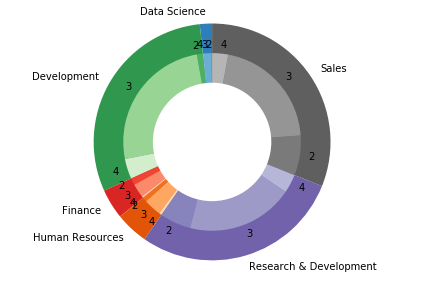

In [79]:
a, b, c,d,e,f=[plt.cm.Blues,plt.cm.Greens, plt.cm.Reds, plt.cm.Oranges,plt.cm.Purples, plt.cm.Greys]

colors_outer=[a(0.7), b(0.7), c(0.7),d(0.7), e(0.7), f(0.7)]
colors_inner=[a(0.6), a(0.5),a(0.4), b(0.6), b(0.4),b(0.2), c(0.6), c(0.4), c(0.2),
              d(0.6), d(0.4),d(0.2), e(0.6), e(0.5),e(0.4), f(0.6), f(0.5), f(0.4)]

plt.pie(outer_sizes, labels=df1.index,startangle=90,frame=True,colors=colors_outer)
plt.pie(inner_sizes,radius=0.75,startangle=90,labels=inner_labels,colors=colors_inner)
fig = plt.gcf()

centre_circle = plt.Circle((0,0),0.5,color='black',fc='white',linewidth=0)
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()

In [80]:
# Defining a function which returns the count and percentage of the feature.
def PIE_CHART_ANALYSIS(predictor):
    pie_count=original_data.groupby(predictor).agg('count')
    labels = pie_count[pie_count.columns[0]].sort_values().index
    counts = pie_count[pie_count.columns[0]].sort_values()
    plt.axis("equal")

    return plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True)       

Text(0.5,1,'promotion')

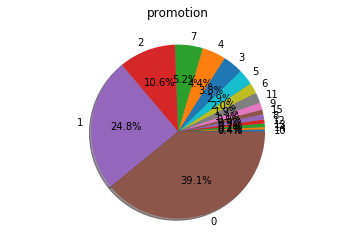

In [81]:
PIE_CHART_ANALYSIS('YearsSinceLastPromotion')
plt.title("promotion")

Text(0.5,1,'exp')

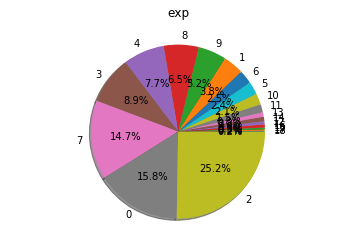

In [82]:
PIE_CHART_ANALYSIS('ExperienceYearsInCurrentRole')
plt.title("exp")

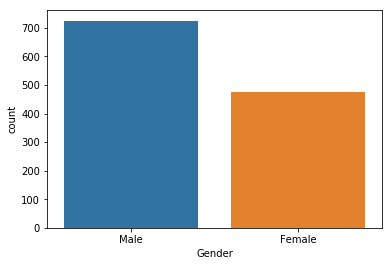

In [83]:
sns.countplot(x="Gender",data=original_data)

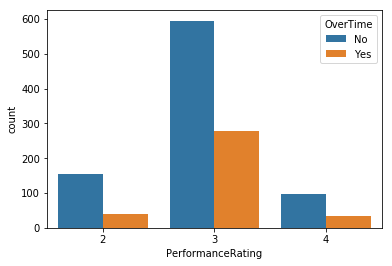

In [84]:
sns.countplot(x="PerformanceRating",data=original_data,hue="OverTime")

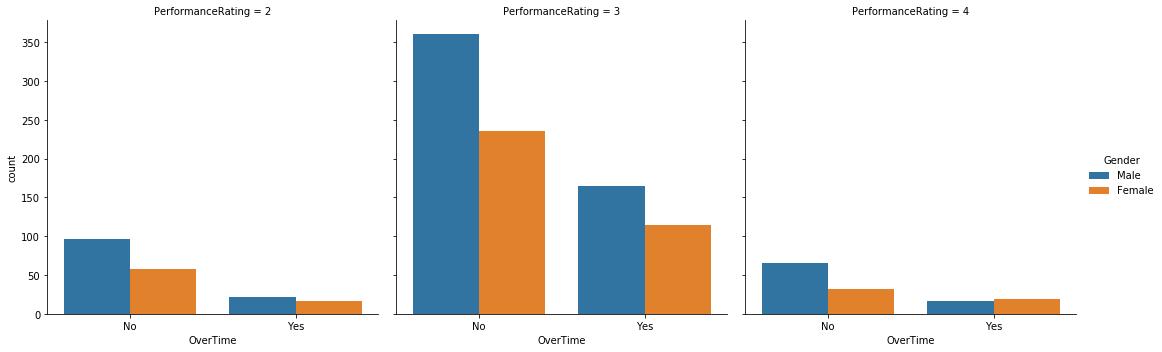

In [85]:
sns.catplot(x="OverTime", hue="Gender", col="PerformanceRating",data=original_data, kind="count")

In [86]:
# Defining a function which returns the histogram and distribution of the feature.
def histogram(predictor):
    return sns.distplot(original_data[predictor])

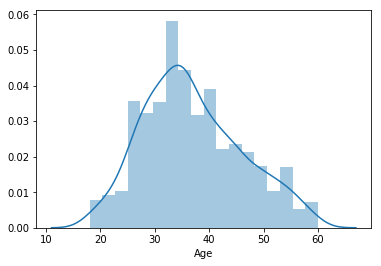

In [87]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

histogram('Age')

## Analysing count plot with seaborn

In [88]:
# Defining a function which plots the count of mentioned columns.
def count_plot(columns_required):
    fig=plt.subplots(figsize=(20,25))                 
    for i, j in enumerate(columns_required):
        plt.subplot(10,2,i+1)
        plt.subplots_adjust(hspace = 1.0)
        sns.countplot(x=j,data = original_data)
        plt.xticks(rotation=35)
        plt.title("No. of employee")

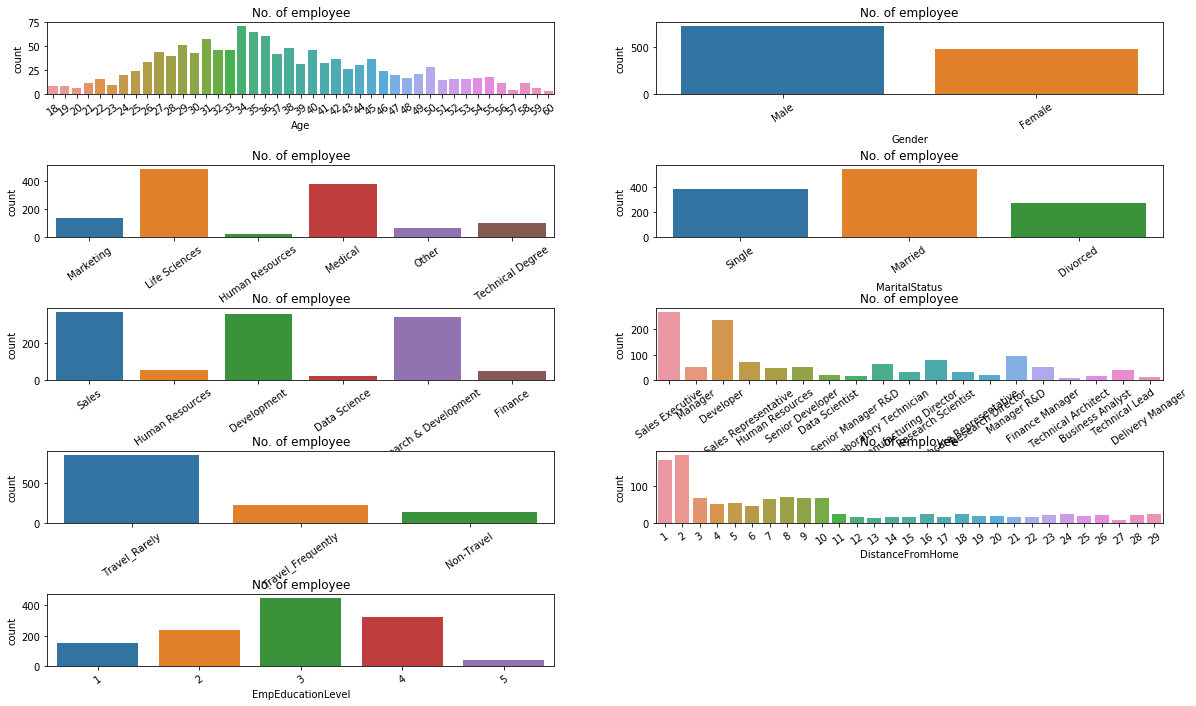

In [89]:
count_plot(original_data.columns[1:10])

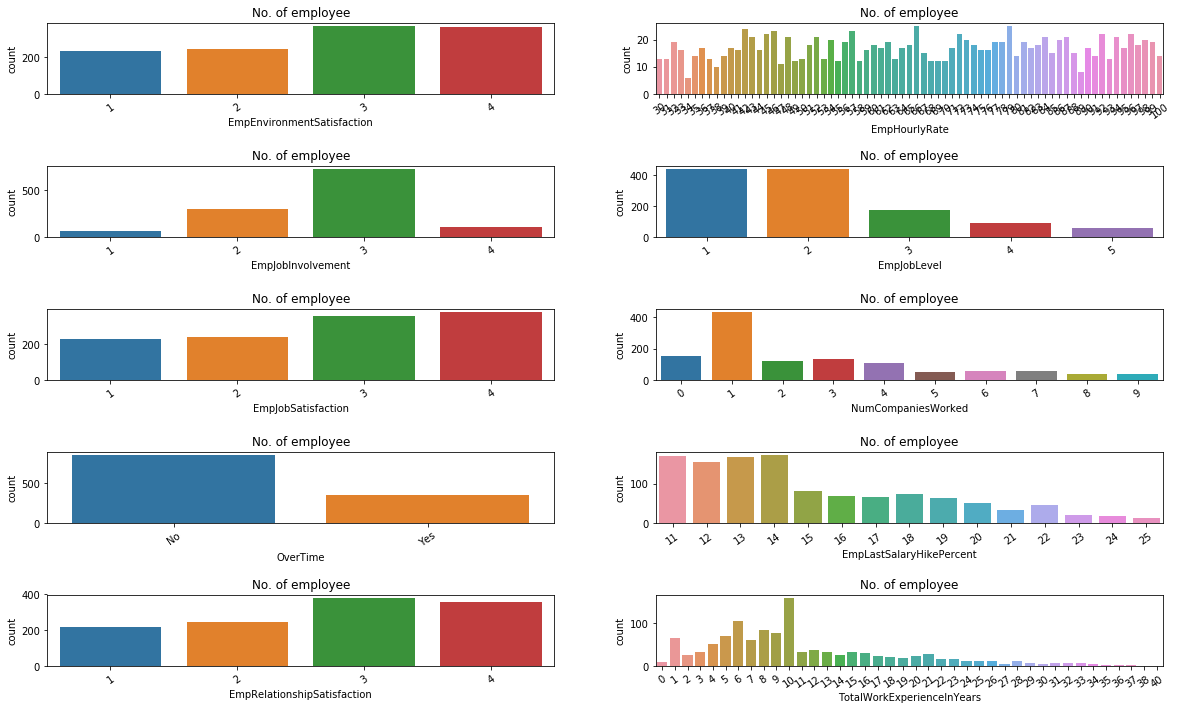

In [90]:
count_plot(original_data.columns[10:20])

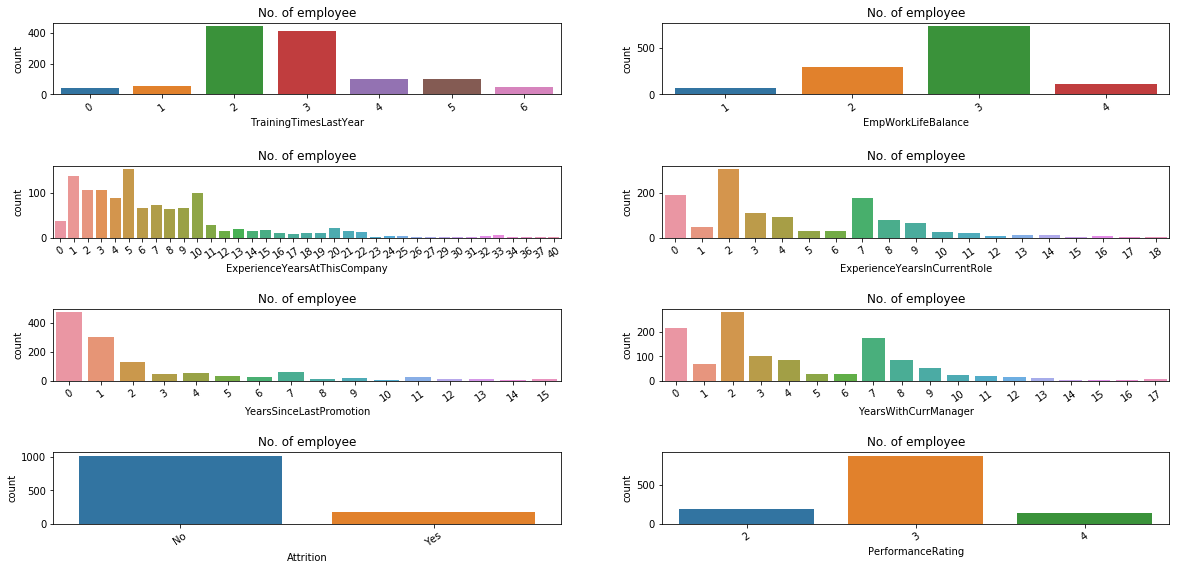

In [91]:
count_plot(original_data.columns[20:])

## Analyze count plot w.r.t performance rating

In [92]:
# Defining a function which plots the count of mentioned columns w.r.t Performance Rating.
def count_with_hue(columns_required):
    fig=plt.subplots(figsize=(30,35))             
    for i, j in enumerate(columns_required):
        plt.subplot(10, 2, i+1)
        plt.subplots_adjust(hspace = 1.0)
        sns.countplot(x=j,data = original_data, hue='PerformanceRating')
        plt.xticks(rotation=40)       
    

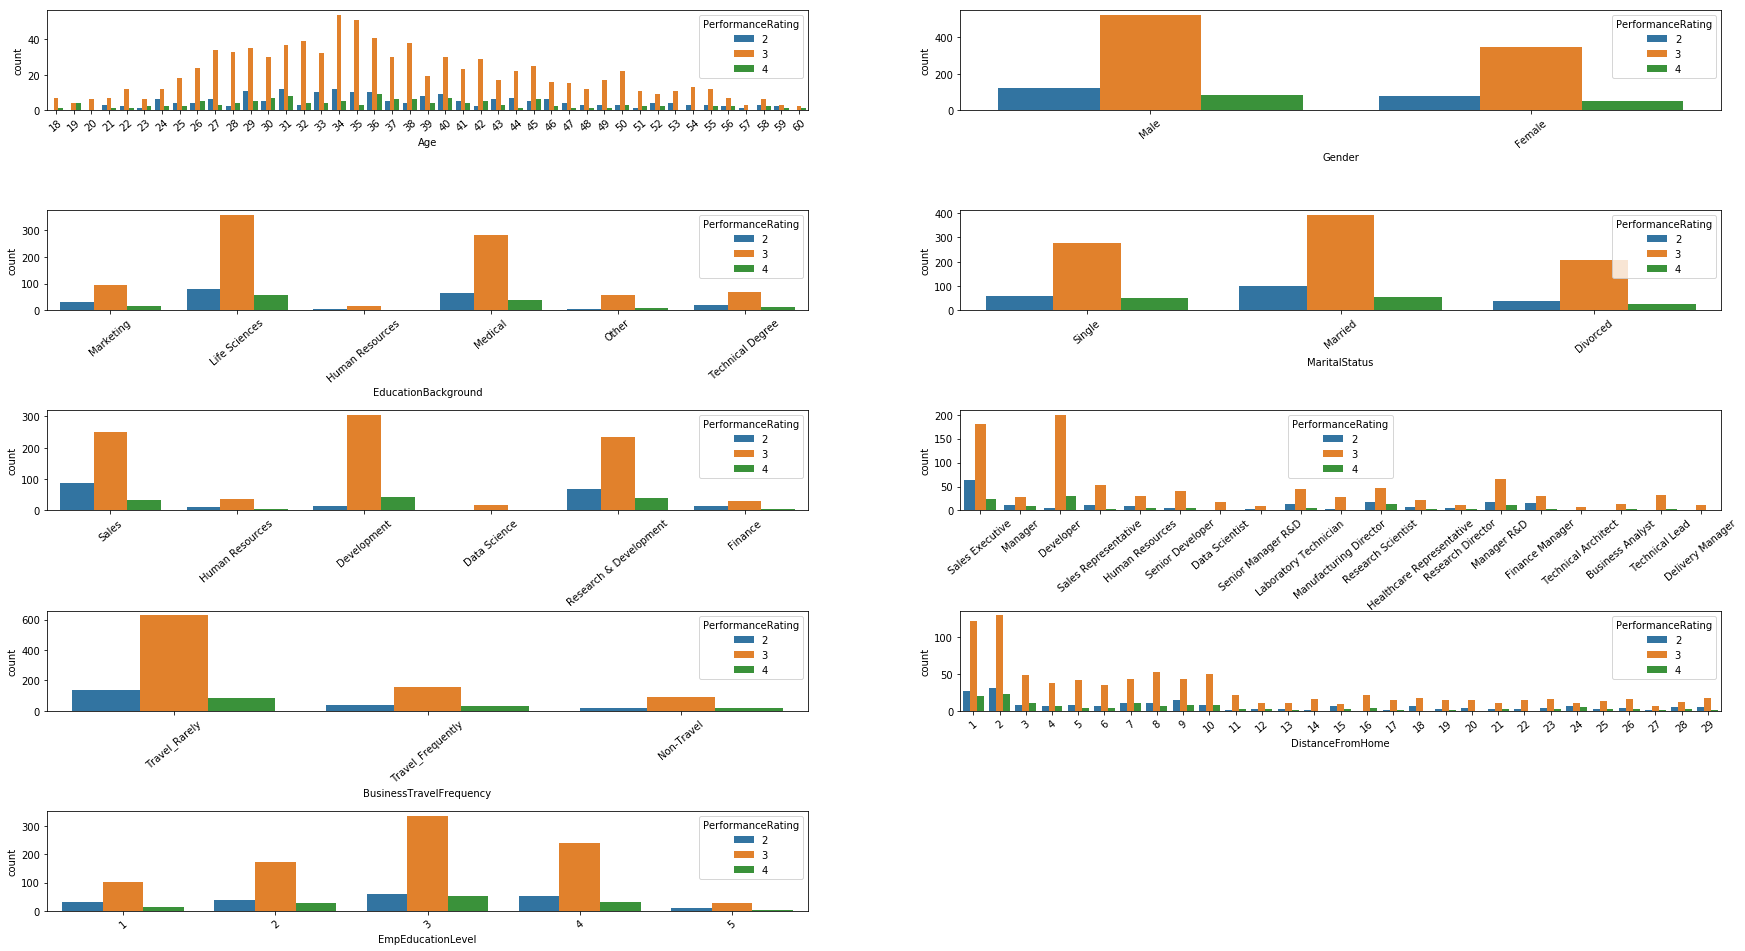

In [93]:
count_with_hue(original_data.columns[1:10])

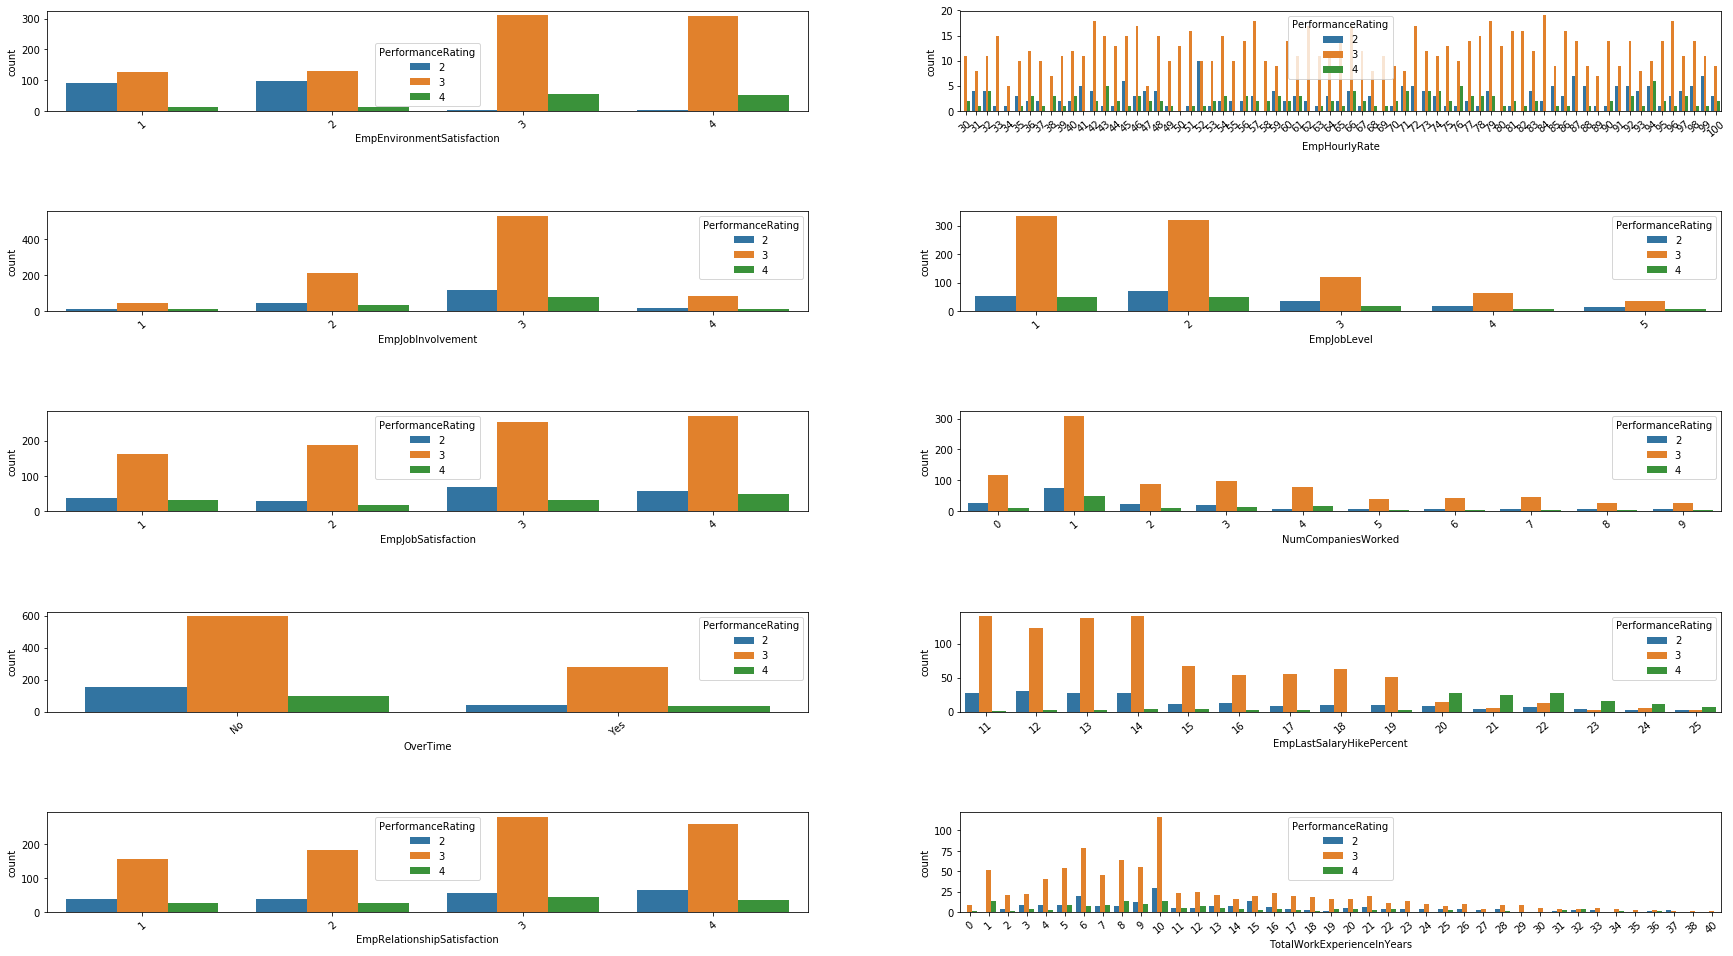

In [94]:
count_with_hue(original_data.columns[10:20])

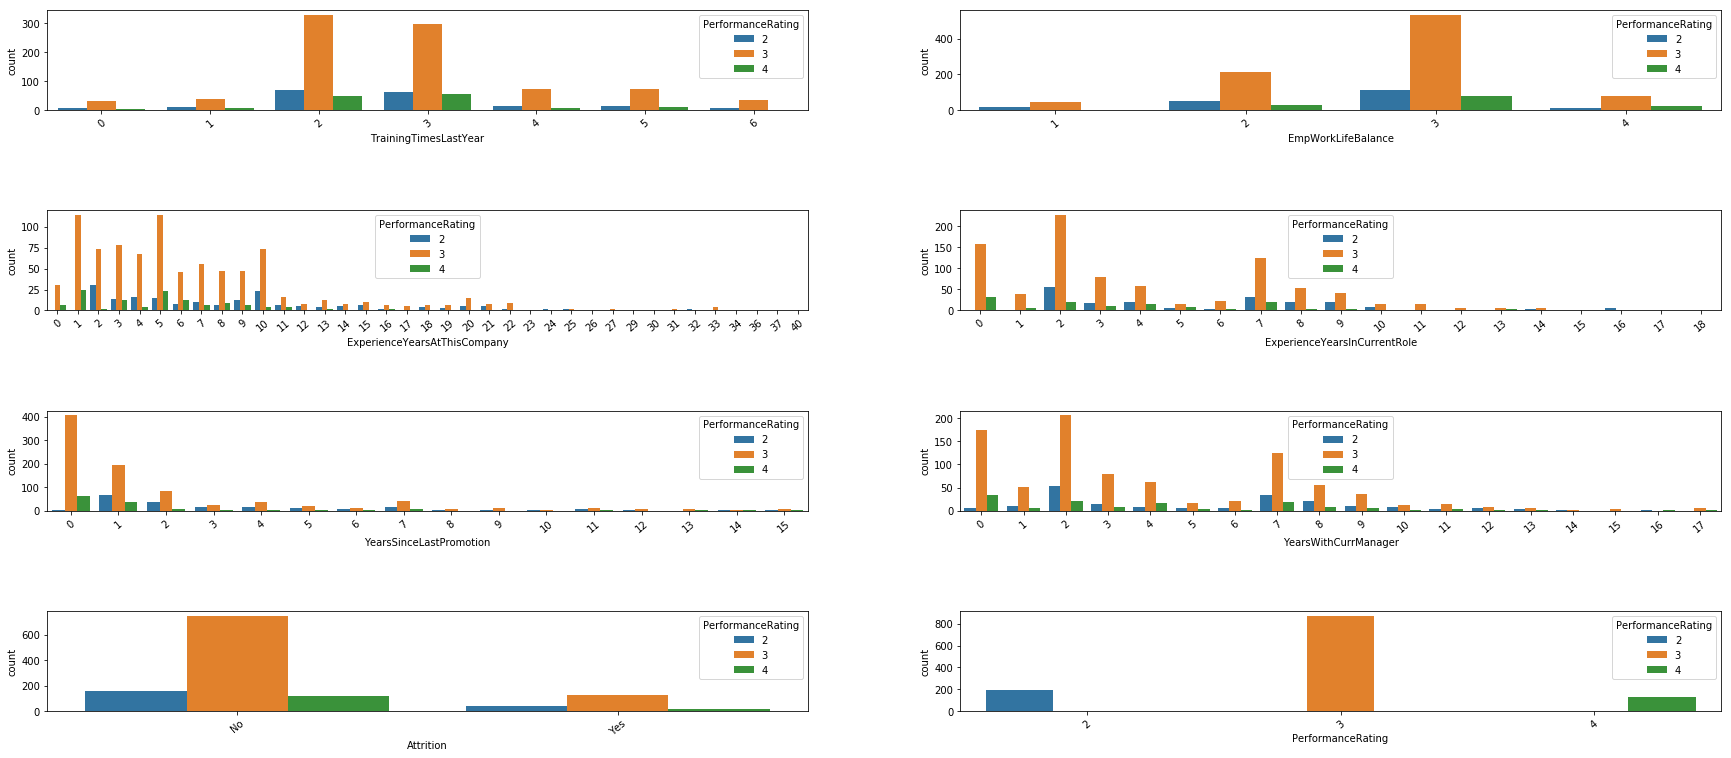

In [95]:
count_with_hue(original_data.columns[20:])

In [96]:
# Analyzing w.r.t categorical data.
categorical_data = original_data.loc[:, original_data.dtypes == np.object]
categorical_data.columns

Index(['EmpNumber', 'Gender', 'EducationBackground', 'MaritalStatus',
       'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency', 'OverTime',
       'Attrition'],
      dtype='object')

In [97]:
# Defining a function which plots the count of categorical columns w.r.t Performance Rating.
def target_with_hue (columns_required):
    fig=plt.subplots(figsize=(30,35))             
    for i, j in enumerate(columns_required):
        plt.subplot(10, 2, i+1)
        plt.subplots_adjust(hspace = 1.0)
        sns.countplot(x='PerformanceRating',data = original_data, hue=j)
        plt.xticks(rotation=40)   

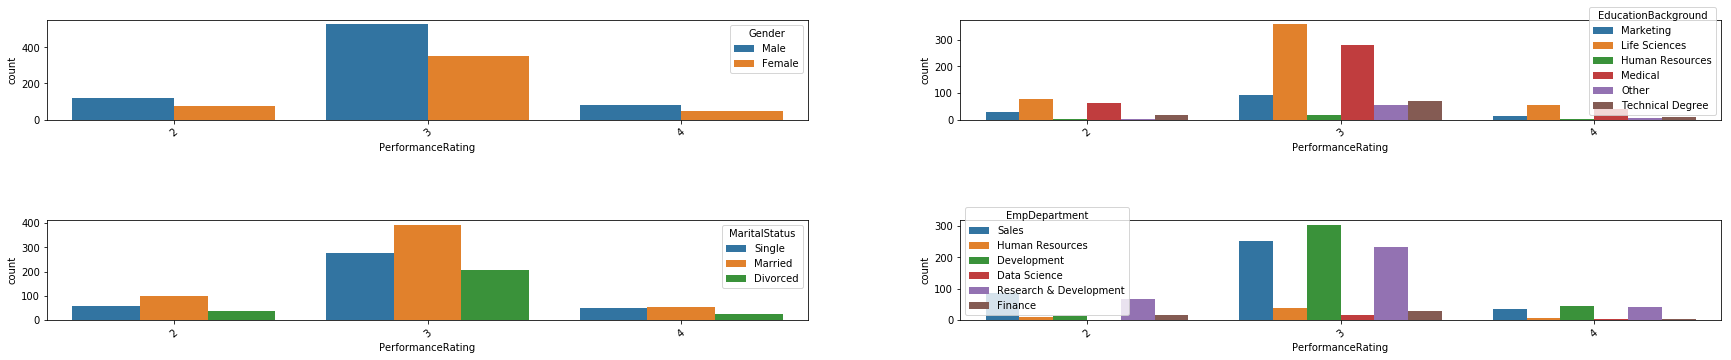

In [98]:
target_with_hue(categorical_data.columns[1:5])

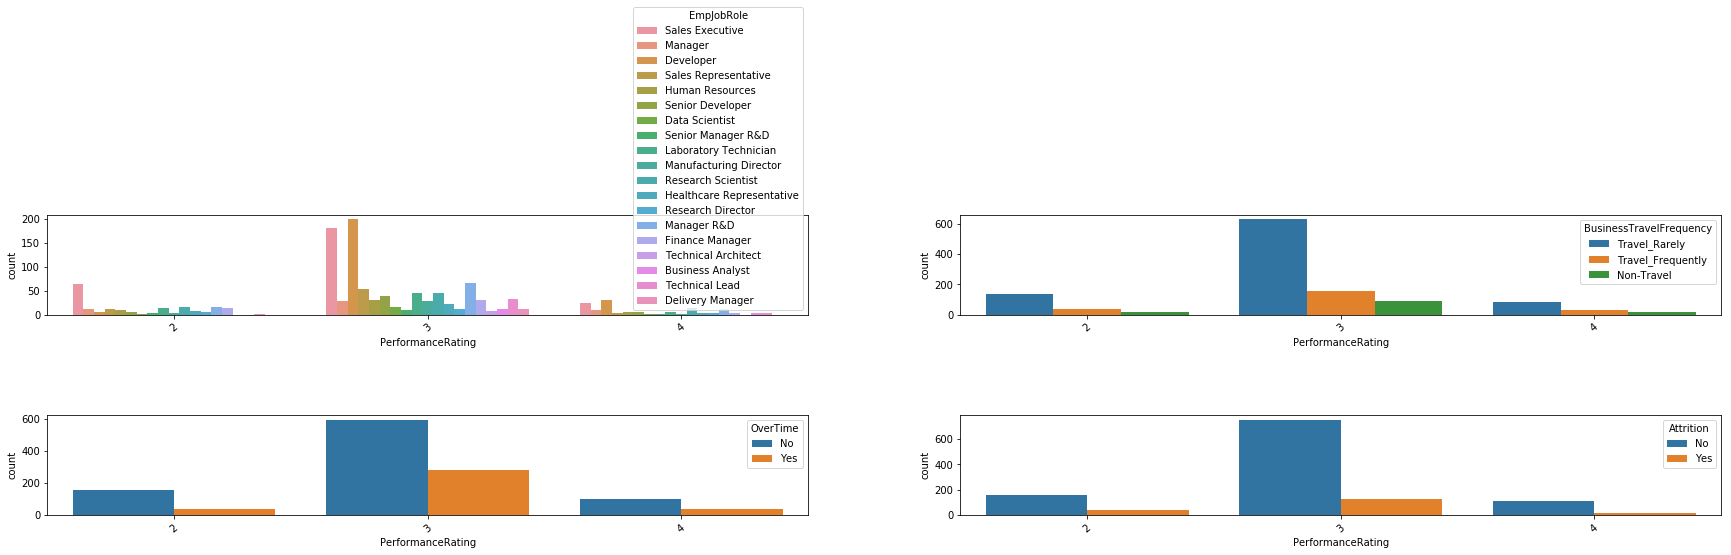

In [99]:
target_with_hue(categorical_data.columns[5:])

# Building the model

In [100]:
# Creating training and testing data using stratified shuffle splitt.

cv = StratifiedShuffleSplit(n_splits=5,test_size=0.20, random_state=1)
for train, test in cv.split(X,y):
    X_train, X_test = X.iloc[train], X.iloc[test] 
    y_train, y_test = y.iloc[train], y.iloc[test]

print('shape of X train data: , shape of y train data:',(X_train.shape,y_train.shape))
print('shape of X test  data: , shape of y test  data:',(X_test.shape,y_test.shape))

shape of X train data: , shape of y train data: ((960, 26), (960,))
shape of X test  data: , shape of y test  data: ((240, 26), (240,))


In [101]:
# Defining a function to check the class distribution in training and testing data.
def data_distribution(train,test):        
    print('y_train class distribution')
    print(train.value_counts(normalize=True))
    print('y_test class distribution')
    print(test.value_counts(normalize=True))

In [102]:
data_distribution(y_train,y_test)

y_train class distribution
3    0.728125
2    0.161458
4    0.110417
Name: PerformanceRating, dtype: float64
y_test class distribution
3    0.729167
2    0.162500
4    0.108333
Name: PerformanceRating, dtype: float64


In [103]:
data.PerformanceRating.value_counts() / len (data.PerformanceRating) *100

3    72.833333
2    16.166667
4    11.000000
Name: PerformanceRating, dtype: float64

In [153]:
# Defining a function to training the tree based model with their feature importances

def treebased_model_training(required_classifier):
    model=required_classifier(random_state=1)
    model.fit(X_train,y_train)
    imp_value = pd.Series(model.feature_importances_ ,index=X.columns).sort_values(ascending=False)
    imp=pd.DataFrame(imp_value,columns=['Importance in %'])
    return imp,model

In [154]:
# Defining a function to predict the tree based model with their feature importances.

def model_outcome (required_classifier):
    treebased_model_training (required_classifier)
    y_predict = model.predict(X_test)
    # We are looking at various performance metrics
    print("Accuracy :",accuracy_score(y_test,y_predict))
    print("Precision:",precision_score(y_test, y_predict,average='weighted'))
    print(classification_report(y_test,y_predict))
    print(pd.crosstab(y_test,y_predict,colnames=['Predicted value']))
    print('*********************************************************')
    # We are measuring the cross validation scores based on multiple scoring parameters
    scores = cross_validate(model, X, y, cv=cv,scoring='precision_macro')  
    print(scores.keys())
    print("cross-validation scores : " ,scores['test_score'])
    print("Accuracy(deviation): %0.2f (+/- %0.2f)" % (scores['test_score'].mean(),
                                                      scores['test_score'].std() * 2))
    print('*********************************************************')    

In [155]:
# Finding the feature importance value through Randomforest classifier.
imp,model= treebased_model_training(RandomForestClassifier)

In [156]:
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [157]:
model_outcome(RandomForestClassifier)

Accuracy : 0.9
Precision: 0.8977608810277059
              precision    recall  f1-score   support

           2       0.87      0.85      0.86        39
           3       0.91      0.95      0.93       175
           4       0.84      0.62      0.71        26

   micro avg       0.90      0.90      0.90       240
   macro avg       0.87      0.81      0.83       240
weighted avg       0.90      0.90      0.90       240

Predicted value     2    3   4
PerformanceRating             
2                  33    6   0
3                   5  167   3
4                   0   10  16
*********************************************************
dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])
cross-validation scores :  [0.88240246 0.94179894 0.86228797 0.91877203 0.87436487]
Accuracy(deviation): 0.90 (+/- 0.06)
*********************************************************


# Finding feature importance

In [158]:
# Feature importance through Randome Forest.
imp[:3]

,Importance in %
EmpLastSalaryHikePercent,0.224971
EmpEnvironmentSatisfaction,0.188290
YearsSinceLastPromotion,0.088405


In [159]:
# Feature importance through statistical method.
stat_feature = SelectKBest(score_func=mutual_info_classif)
fit = stat_feature.fit(X,y)
scores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(X.columns)

featureScores = pd.concat([columns,scores],axis=1)
featureScores.columns = ['Features','Importance score']  
featureScores.nlargest(3,'Importance score')

,Features,Importance score
9,EmpEnvironmentSatisfaction,0.174574
16,EmpLastSalaryHikePercent,0.158995
23,YearsSinceLastPromotion,0.073071


In [160]:
# Findong features that has highest impact on target
corr[corr.PerformanceRating >= 0.1 ][:4]

,PerformanceRating
PerformanceRating,1.000000
EmpEnvironmentSatisfaction,0.395561
EmpLastSalaryHikePercent,0.333722
YearsSinceLastPromotion,0.167629


# Feature Selection

In [161]:
# Performing feature selection based on threshold value.

for value in imp.values:
    
    selection = SelectFromModel(model, threshold=value, prefit=True)
    X_train_new = selection.transform(X_train)
    
    # Checking the features performance till 12 iterations   
    if X_train_new.shape[1] <= 12:                
        selected_features= X_train.columns[(selection.get_support())]
        print('******************************************************************')       
        print(selected_features)
                
    if X_train_new.shape[1] <= 12:                
        print('Number of Features :',X_train_new.shape[1])
        # training model with <= threshold value
        selection_model = RandomForestClassifier()
        selection_model.fit(X_train_new , y_train)
    
        # evaluating model
        X_test_new = selection.transform(X_test)
        pred_y = selection_model.predict(X_test_new)
        predictions = [round(value) for value in pred_y]
        accuracy = accuracy_score(y_test, predictions)
        print("importance value=%.3f,  Accuracy: %.2f%%" % (value, accuracy*100.0))
        
    else: exit
    

******************************************************************
Index(['EmpLastSalaryHikePercent'], dtype='object')
Number of Features : 1
importance value=0.225,  Accuracy: 78.33%
******************************************************************
Index(['EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent'], dtype='object')
Number of Features : 2
importance value=0.188,  Accuracy: 79.58%
******************************************************************
Index(['EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
       'YearsSinceLastPromotion'],
      dtype='object')
Number of Features : 3
importance value=0.088,  Accuracy: 84.17%
******************************************************************
Index(['EmpJobRole', 'EmpEnvironmentSatisfaction', 'EmpLastSalaryHikePercent',
       'YearsSinceLastPromotion'],
      dtype='object')
Number of Features : 4
importance value=0.055,  Accuracy: 88.33%
******************************************************************
Index(['EmpJo

# Building model with optimized features

In [162]:
# Assigning new variable with features selected from SelectFromModel.
data6=X.loc[:,['EmpDepartment', 'EmpJobRole', 'EmpEnvironmentSatisfaction',
       'EmpHourlyRate', 'EmpLastSalaryHikePercent', 'YearsSinceLastPromotion']]
data6.shape

(1200, 6)

In [163]:
data6.head()

,EmpDepartment,EmpJobRole,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpLastSalaryHikePercent,YearsSinceLastPromotion
0,5,13,4,55,12,0
1,5,13,4,42,12,1
2,5,13,4,48,21,1
3,3,8,2,73,15,12
4,5,13,1,84,14,2


In [164]:
cv = StratifiedShuffleSplit(n_splits=5,test_size=0.20, random_state=1)
for train, test in cv.split(data6,y):
    X_train_6, X_test_6 = data6.iloc[train], data6.iloc[test] 
    y_train_6, y_test_6 = y.iloc[train], y.iloc[test]

print('shape of X train data: , shape of y train data:',(X_train_6.shape,y_train_6.shape))
print('shape of X test  data: , shape of y test  data:',(X_test_6.shape,y_test_6.shape))

shape of X train data: , shape of y train data: ((960, 6), (960,))
shape of X test  data: , shape of y test  data: ((240, 6), (240,))


In [165]:
data_distribution(y_train_6,y_test_6)

y_train class distribution
3    0.728125
2    0.161458
4    0.110417
Name: PerformanceRating, dtype: float64
y_test class distribution
3    0.729167
2    0.162500
4    0.108333
Name: PerformanceRating, dtype: float64


In [166]:
# Training the model and doing the prediction with optimized features.
model_6_RF=RandomForestClassifier(random_state=1)
model_6_RF.fit(X_train_6,y_train_6)
y_predict_6 = model_6_RF.predict(X_test_6)

print("Accuracy :",accuracy_score(y_test_6,y_predict_6))
print(classification_report(y_test_6,y_predict_6))
pd.crosstab(y_test_6,y_predict_6)

Accuracy : 0.9125
              precision    recall  f1-score   support

           2       0.97      0.77      0.86        39
           3       0.91      0.97      0.94       175
           4       0.83      0.73      0.78        26

   micro avg       0.91      0.91      0.91       240
   macro avg       0.90      0.82      0.86       240
weighted avg       0.91      0.91      0.91       240



col_0,2,3,4
PerformanceRating,,,
2,30,9,0
3,1,170,4
4,0,7,19


In [167]:
# Comparing with XGBoost Classifier.
model_6=XGBClassifier(random_state=1)
model_6.fit(X_train_6,y_train_6)
y_predict_6 = model_6.predict(X_test_6)

print("Accuracy :",accuracy_score(y_test_6,y_predict_6))
print(classification_report(y_test_6,y_predict_6))
print(pd.DataFrame(pd.crosstab(y_test_6,y_predict_6)))

Accuracy : 0.9291666666666667
              precision    recall  f1-score   support

           2       0.97      0.82      0.89        39
           3       0.93      0.98      0.95       175
           4       0.87      0.77      0.82        26

   micro avg       0.93      0.93      0.93       240
   macro avg       0.92      0.86      0.89       240
weighted avg       0.93      0.93      0.93       240

col_0               2    3   4
PerformanceRating             
2                  32    7   0
3                   1  171   3
4                   0    6  20


In [168]:
# Measuring the cross validation scores based on multiple scoring parameters.
scoring = ['precision_macro', 'recall_macro']
scores_6 = cross_validate(model_6, data6, y, cv=cv,scoring=scoring)  

print(scores_6.keys())
print("cross-validation scores : " ,scores_6['test_precision_macro'])
print("Accuracy (deviation) : %0.2f (+/- %0.2f)"
      % (scores_6['test_precision_macro'].mean(), scores_6['test_precision_macro'].std() * 2))

dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'train_precision_macro', 'test_recall_macro', 'train_recall_macro'])
cross-validation scores :  [0.87905484 0.87682203 0.81893218 0.88943646 0.92287   ]
Accuracy (deviation) : 0.88 (+/- 0.07)


In [169]:
# Checking cross validation prediction accuracy.
predicted=cross_val_predict(model_6, data6, y)
accuracy_score(y,predicted)

0.9116666666666666

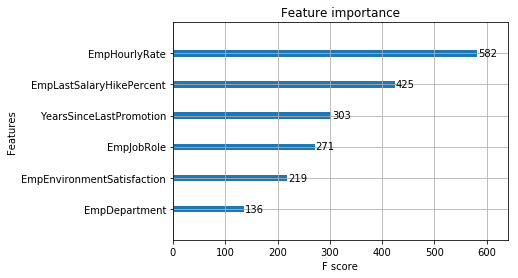

In [170]:
# Plotting the Feature Importances of XGBoost classifier.
plot_importance(model_6)

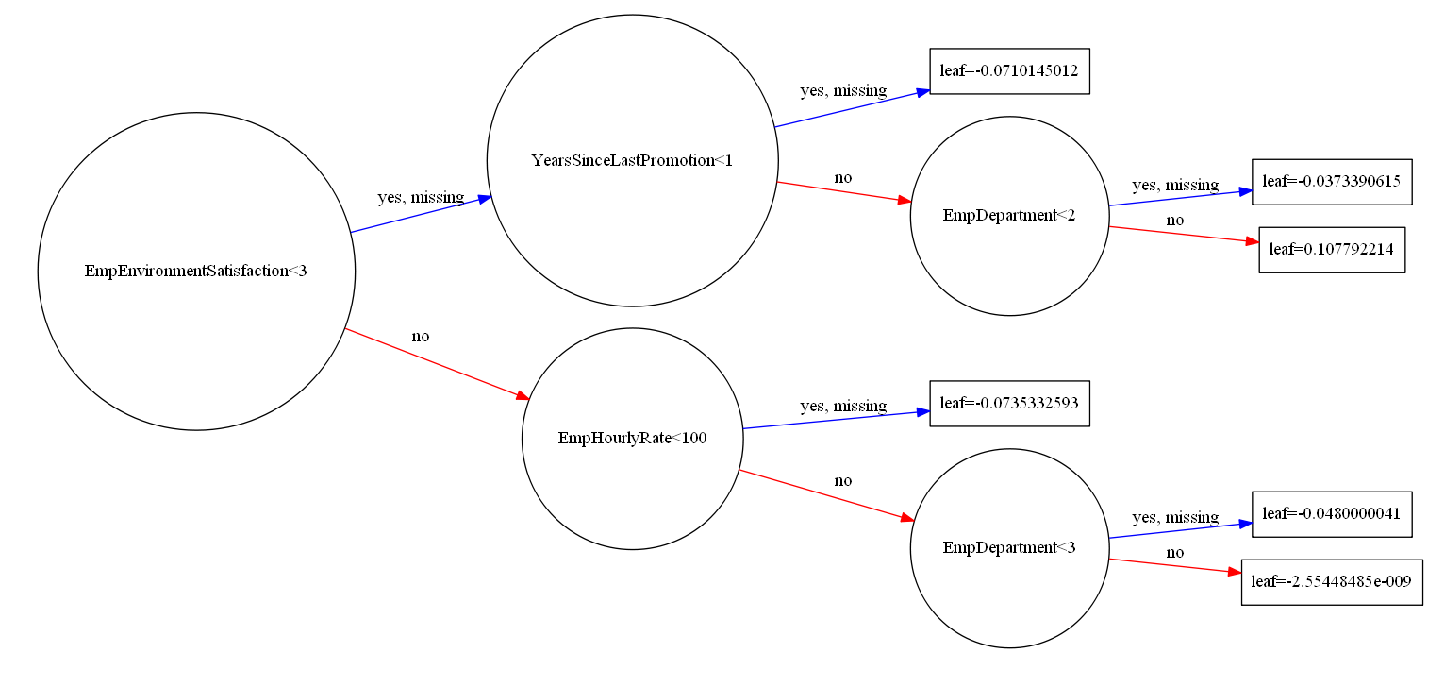

In [171]:
# We are plotting the first decision tree of XGBoost classifier
plot_tree(model_6,rankdir='LR',num_trees=0)
fig = plt.gcf()
fig.set_size_inches(25,20)

# Tuning Hyperparameter of model

In [172]:
# Performing the grid search for tuning the hyperperameters of our model.
parameters = {'n_estimators': [80,100],'max_depth': [3,4,5],'gamma': [1,1.25,1.5,1.75],'learning_rate':[0.01,0.05,0.1,0.25] }

grid = GridSearchCV(model_6, param_grid=parameters,cv=cv, n_jobs=-1,scoring=scoring,refit='precision_macro')
grid.fit(X_train_6,y_train_6)
y_predict_grid = grid.predict(X_test_6)

In [173]:
# Printing accuracy and best parameters of grid search
print("best score :" ,grid.best_score_)
print(grid.best_params_)
print("Accuracy :",accuracy_score(y_test_6,y_predict_grid))
print("Precision:",precision_score(y_test_6, y_predict_grid,average='weighted'))
print(classification_report(y_test_6,y_predict_grid))
pd.crosstab(y_test_6,y_predict_grid)

best score : 0.8933599210611666
{'gamma': 1.75, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
Accuracy : 0.9291666666666667
Precision: 0.9294281126482213
              precision    recall  f1-score   support

           2       0.97      0.82      0.89        39
           3       0.93      0.98      0.95       175
           4       0.87      0.77      0.82        26

   micro avg       0.93      0.93      0.93       240
   macro avg       0.92      0.86      0.89       240
weighted avg       0.93      0.93      0.93       240



col_0,2,3,4
PerformanceRating,,,
2,32,7,0
3,1,171,3
4,0,6,20
